# No-Transaction Band Network

In [1]:
from Utils import prices_torch as pt
from Utils import tensors as ts
from Env import rewards_torch as rt

In [2]:
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb

In [3]:
sb.set_style('whitegrid')

FONTSIZE = 10
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

In [4]:
# In each epoch, N_PATHS brownian motion time-series are generated.
N_PATHS = 5000
# How many times a model is updated in the experiment.
N_EPOCHS = 200

In [5]:
def to_numpy(tensor: th.Tensor) -> np.array:
    return tensor.cpu().detach().numpy()

In [58]:
from Env.env_torch import BSMarketTorch

env_config = \
{'cost': 1e-3,
 'dividend': 0.0,
 'drift': 1.0,
 'freq': 1,
 'gen_name': 'gbm',
 'init_price': 1.0,
 'maturity': 30,
 'n_assets': 5000,
 'payoff': 'european',
 'payoff_coeff': 1.0,
 'period_unit': 365,
 'random_drift': False,
 'random_vol': False,
 'reward_fn': 'mean var',
 'reward_fn_kwargs': {},
 'reward_mode': 'pnl',
 'risk_free_interest': 0.0,
 'strike': 1.0,
 'volatility': 0.2}

env = BSMarketTorch(**env_config)

env 'BSMarket was created!


In [59]:
def compute_pnl(hedging_model: nn.Module,
                n_assets,
                n_periods=30, volatility=0.2, drift=0.0,
                dt=1/365, cost = 1e-3) -> th.Tensor:

    # prices = pt.geometric_brownian_motion(
    #     n_assets, n_periods, volatility=volatility, drift=0.0, init_price=1.0, dt=dt)
    env.reset()
    prices = env.underlying_prices.clone()
    options = env.option_prices.clone()

    hedge = th.zeros(n_assets).reshape(-1)
    pnl = 0
    # Simulate hedging over time.
    for n in range(prices.shape[0] - 1):
        prev_hedge = hedge
        moneyness = prices[n, :, None]
        expiry = th.full_like(moneyness, (n_periods-1-n) * dt)
        expiry = th.where(expiry==0, th.tensor([1e-6]), expiry)
        vol = th.full_like(moneyness, volatility)
        # mu = th.full_like(moneyness, drift)
        x = {'obs': th.cat([moneyness, expiry, vol], 1),
             'prev_hedge': prev_hedge}

        # Infer a preferable hedge ratio.
        hedge = hedging_model(x)

        # Receive profit/loss from the original asset.
        pnl += hedge * (prices[n + 1] - prices[n])
        # Pay transaction cost.
        pnl -= cost * th.abs(hedge - prev_hedge) * prices[n]
        pnl += options[n] - options[n+1]

    # Pay the option's payoff to the customer.
    pnl -= options[n-1] - pt.european_option_payoff(prices)

    return pnl

In [60]:
def episode_reward(env, model):
    obs = env.reset()
    done, info = False, {}
    while not done:
        action = model(obs)
        obs, reward, done, info = env.step(action)

    return obs, env.raw_reward, done, info

In [64]:
class NoTransactionBandNet(th.nn.Module):

    def __init__(self, in_features=3):
        super().__init__()

        # A four-layer MLP with 32 hidden neurons in each layer
        mlp = ts.create_module(in_features, 2, [32, 32, 32, 32])
        self.mlp = nn.Sequential(*mlp)
        self.tanh = nn.Tanh()

    def forward(self, obs):
        x = obs['obs']
        prev = obs['prev_hedge']
        delta = pt.european_call_delta(x[:, 0], x[:, 1], x[:, 2], x[:, 3])
        # delta = pt.european_call_delta(x[:, 0], x[:, 1], x[:, 2])

        scaler = 2.0 - 1e-5
        delta = (delta * scaler - scaler / 2).atanh()

        if th.isinf(delta).any():
            raise ValueError('inf value passed!')

        action = self.mlp(x)
        lower = th.tanh(delta - F.leaky_relu(action[:, 0]))
        upper = th.tanh(delta + F.leaky_relu(action[:, 1]))

        action = ts.clamp(2.0*prev-1.0, lower, upper)

        return (action + 1.0) * 0.5

class FFN(nn.Module):
    def __init__(self, in_features, net_arch, activation_fn=nn.ReLU, net_kwargs=None):
        super(FFN, self).__init__()
        mlp = ts.create_module(in_features+1, 1, net_arch, activation_fn, squash_output=True, net_kwargs=net_kwargs)
        self.mlp = nn.Sequential(*mlp)
        self.flatten = nn.Flatten(0)

    def forward(self, obs):
        x = th.cat([obs['obs'], obs['prev_hedge'].view(-1, 1)], dim=1)
        delta = pt.european_call_delta(x[:, 0], x[:, 1], x[:, 2], x[:, 3]) - 0.5
        action = self.mlp(x)
        action = self.flatten(action)
        action = delta + action
        return action / 3.0 + 0.5

In [79]:
th.manual_seed(42)
model_ntb = NoTransactionBandNet(4)

th.manual_seed(42)
model_ffn = FFN(4, [32, 32, 32, 32])

print(model_ntb)
print(model_ffn)

NoTransactionBandNet(
  (mlp): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=2, bias=True)
  )
  (tanh): Tanh()
)
FFN(
  (mlp): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Tanh()
  )
  (flatten): Flatten(start_dim=0, end_dim=-1)
)


### Compute profit and loss before training

In [80]:
th.manual_seed(42)
pnl_ntb = episode_reward(env, model_ntb)[1]
th.manual_seed(42)
pnl_ffn = episode_reward(env, model_ffn)[1]

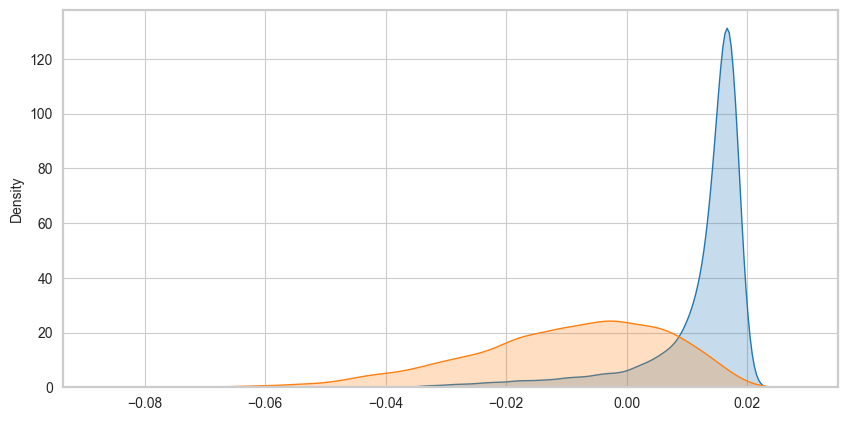

In [81]:
sb.kdeplot(to_numpy(pnl_ntb), shade=True)
sb.kdeplot(to_numpy(pnl_ffn), shade=True)
plt.show()

In [82]:
from tqdm import tqdm

def fit(
    hedging_model: th.nn.Module, cost: float, n_epochs):
    optim = th.optim.Adam(hedging_model.parameters())

    loss_history = []
    progress = tqdm(range(n_epochs))

    for _ in progress:
        optim.zero_grad()
        pnl = episode_reward(env, hedging_model)[1]
        loss = -rt.pnl_entropic_reward(pnl)
        loss.backward()
        optim.step()

        progress.desc = f"Loss={loss:.5f}"
        loss_history.append(loss.item())

    return loss_history

In [83]:
th.manual_seed(42)
history_ntb = fit(model_ntb, 1e-3, 300)
th.manual_seed(42)
history_ffn = fit(model_ffn, 1e-3, 300)

Loss=0.98355: 100%|██████████| 300/300 [01:06<00:00,  4.49it/s]


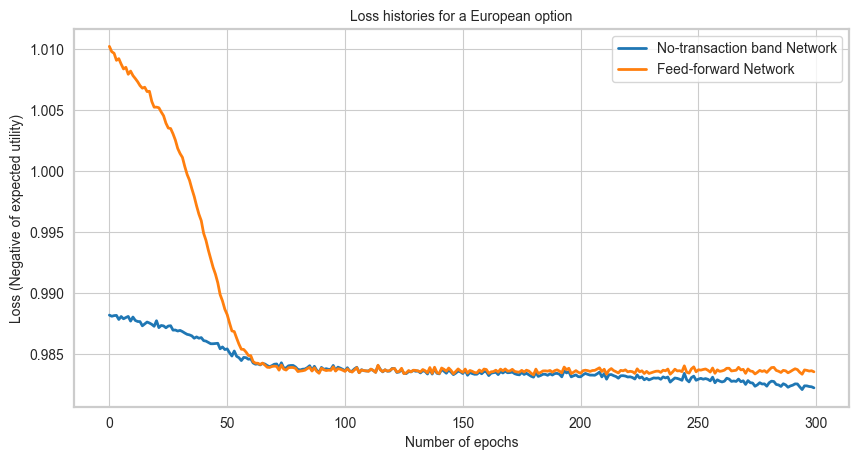

In [84]:
plt.figure()
plt.plot(history_ntb, label="No-transaction band Network")
plt.plot(history_ffn, label="Feed-forward Network")
plt.xlabel("Number of epochs")
plt.ylabel("Loss (Negative of expected utility)")
plt.title("Loss histories for a European option")
plt.legend()
plt.show()

The learning histories above demonstrate that the no-transaction band network can be trained much quicker than the ordinary feed-forward network.

The fluctuations observed after around 100th epoch are mostly due to variances of Monte Carlo paths of the asset prices.

### Compute the profit-loss distributions with hedging

In [88]:
pnl_ntb = episode_reward(env, model_ntb, )[1]
pnl_ffn = episode_reward(env, model_ffn, )[1]

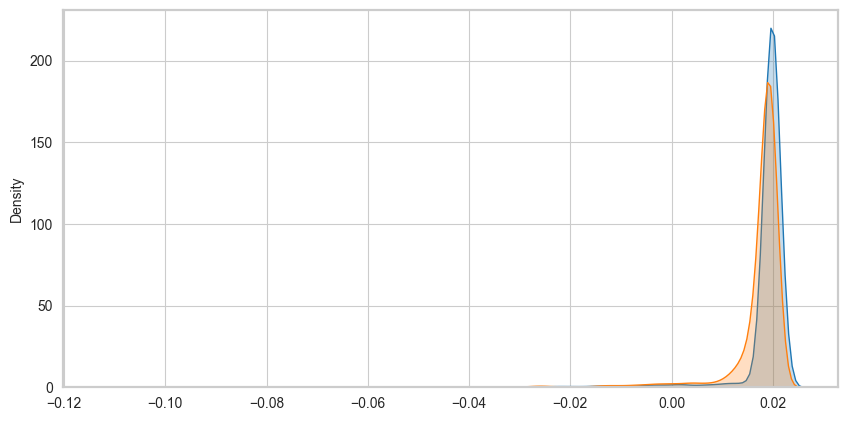

ntb: 0.0178, 0.0090
ffn: 0.0165, 0.0086
ntb: -0.0156
ffn: -0.0157


In [89]:
sb.kdeplot(to_numpy(pnl_ntb), shade=True)
sb.kdeplot(to_numpy(pnl_ffn), shade=True)
plt.show()

print(f'ntb: {pnl_ntb.mean():.4f}, {pnl_ntb.std():.4f}')
print(f'ffn: {pnl_ffn.mean():.4f}, {pnl_ffn.std():.4f}')
print(f'ntb: {rt.cvar_reward(pnl_ntb):.4f}')
print(f'ffn: {rt.cvar_reward(pnl_ffn):.4f}')

The histograms of the profit and loss after hedging look like above.

The no-transaction band network saves on transaction cost while avoiding great losses.

### Evaluate the best premium of the derivative

Now, we are ready to define the premium of the derivative.

Premium of a derivative is defined as the guaranteed amount of cash which is as preferable as the profit-loss after hedging in terms of the exponential utility.

In [19]:
def evaluate_premium(
    hedging_model: th.nn.Module,
    payoff: typing.Callable[[th.Tensor], th.Tensor],
    cost: float,
    n_times=20,
) -> float:
    """
    Evaluate the premium of the given derivative.

    Parameters
    ----------
    - hedging_model : th.nn.Module
        Hedging model to fit.
    - payoff : callable[[th.Tensor], th.Tensor]
        Payoff function of the derivative to hedege.
    - cost : float, default 0.0
        Transaction cost of underlying asset.
    - n_times : int, default 20
        If `n_times > 1`, return ensemble mean of the results
        from multiple simulations.

    Returns
    -------
    premium : float
    """
    with th.no_grad():
        p = lambda: -to_premium(
            compute_profit_and_loss(hedging_model, payoff, cost=cost)
        ).item()
        return float(np.mean([p() for _ in range(n_times)]))

In [20]:
th.manual_seed(42)
premium_ntb = evaluate_premium(model_ntb, european_option_payoff, cost=1e-3)
th.manual_seed(42)
premium_ffn = evaluate_premium(model_ffn, european_option_payoff, cost=1e-3)

The no-transaction band network allows for a cheaper price.

In [21]:
print("Premium of a European option evaluated by the no-transaction band network :\t", premium_ntb)
print("Premium of a European option evaluated by the feed-forward band network   :\t", premium_ffn)

Premium of a European option evaluated by the no-transaction band network :	 0.022544096410274505
Premium of a European option evaluated by the feed-forward band network   :	 0.02277116635814309


In [22]:
premium_reduced = (premium_ffn - premium_ntb) / premium_ffn * 100
print("Reduced premium of a European option :\t", f"{premium_reduced:.4f} %")

Reduced premium of a European option :	 0.9972 %


## Experiment: Lookback Option

Let us carry out the same experiment for a lookback option.

Although we omit the cumulative maximum of the asset price, which is an important feature for a lookback option, for simlicity, the no-transaction band network attains a fairly good hedging strategy.

### Create hedging models

In [23]:
th.manual_seed(42)
model_ntb = NoTransactionBandNet().to(DEVICE)
th.manual_seed(42)
model_ffn = FeedForwardNet().to(DEVICE)

### Fit hedging models

In [24]:
th.manual_seed(42)
history_ntb = fit(model_ntb, lookback_option_payoff, cost=1e-3)
th.manual_seed(42)
history_ffn = fit(model_ffn, lookback_option_payoff, cost=1e-3)

Loss=1.01891: 100%|██████████| 200/200 [00:11<00:00, 16.80it/s]


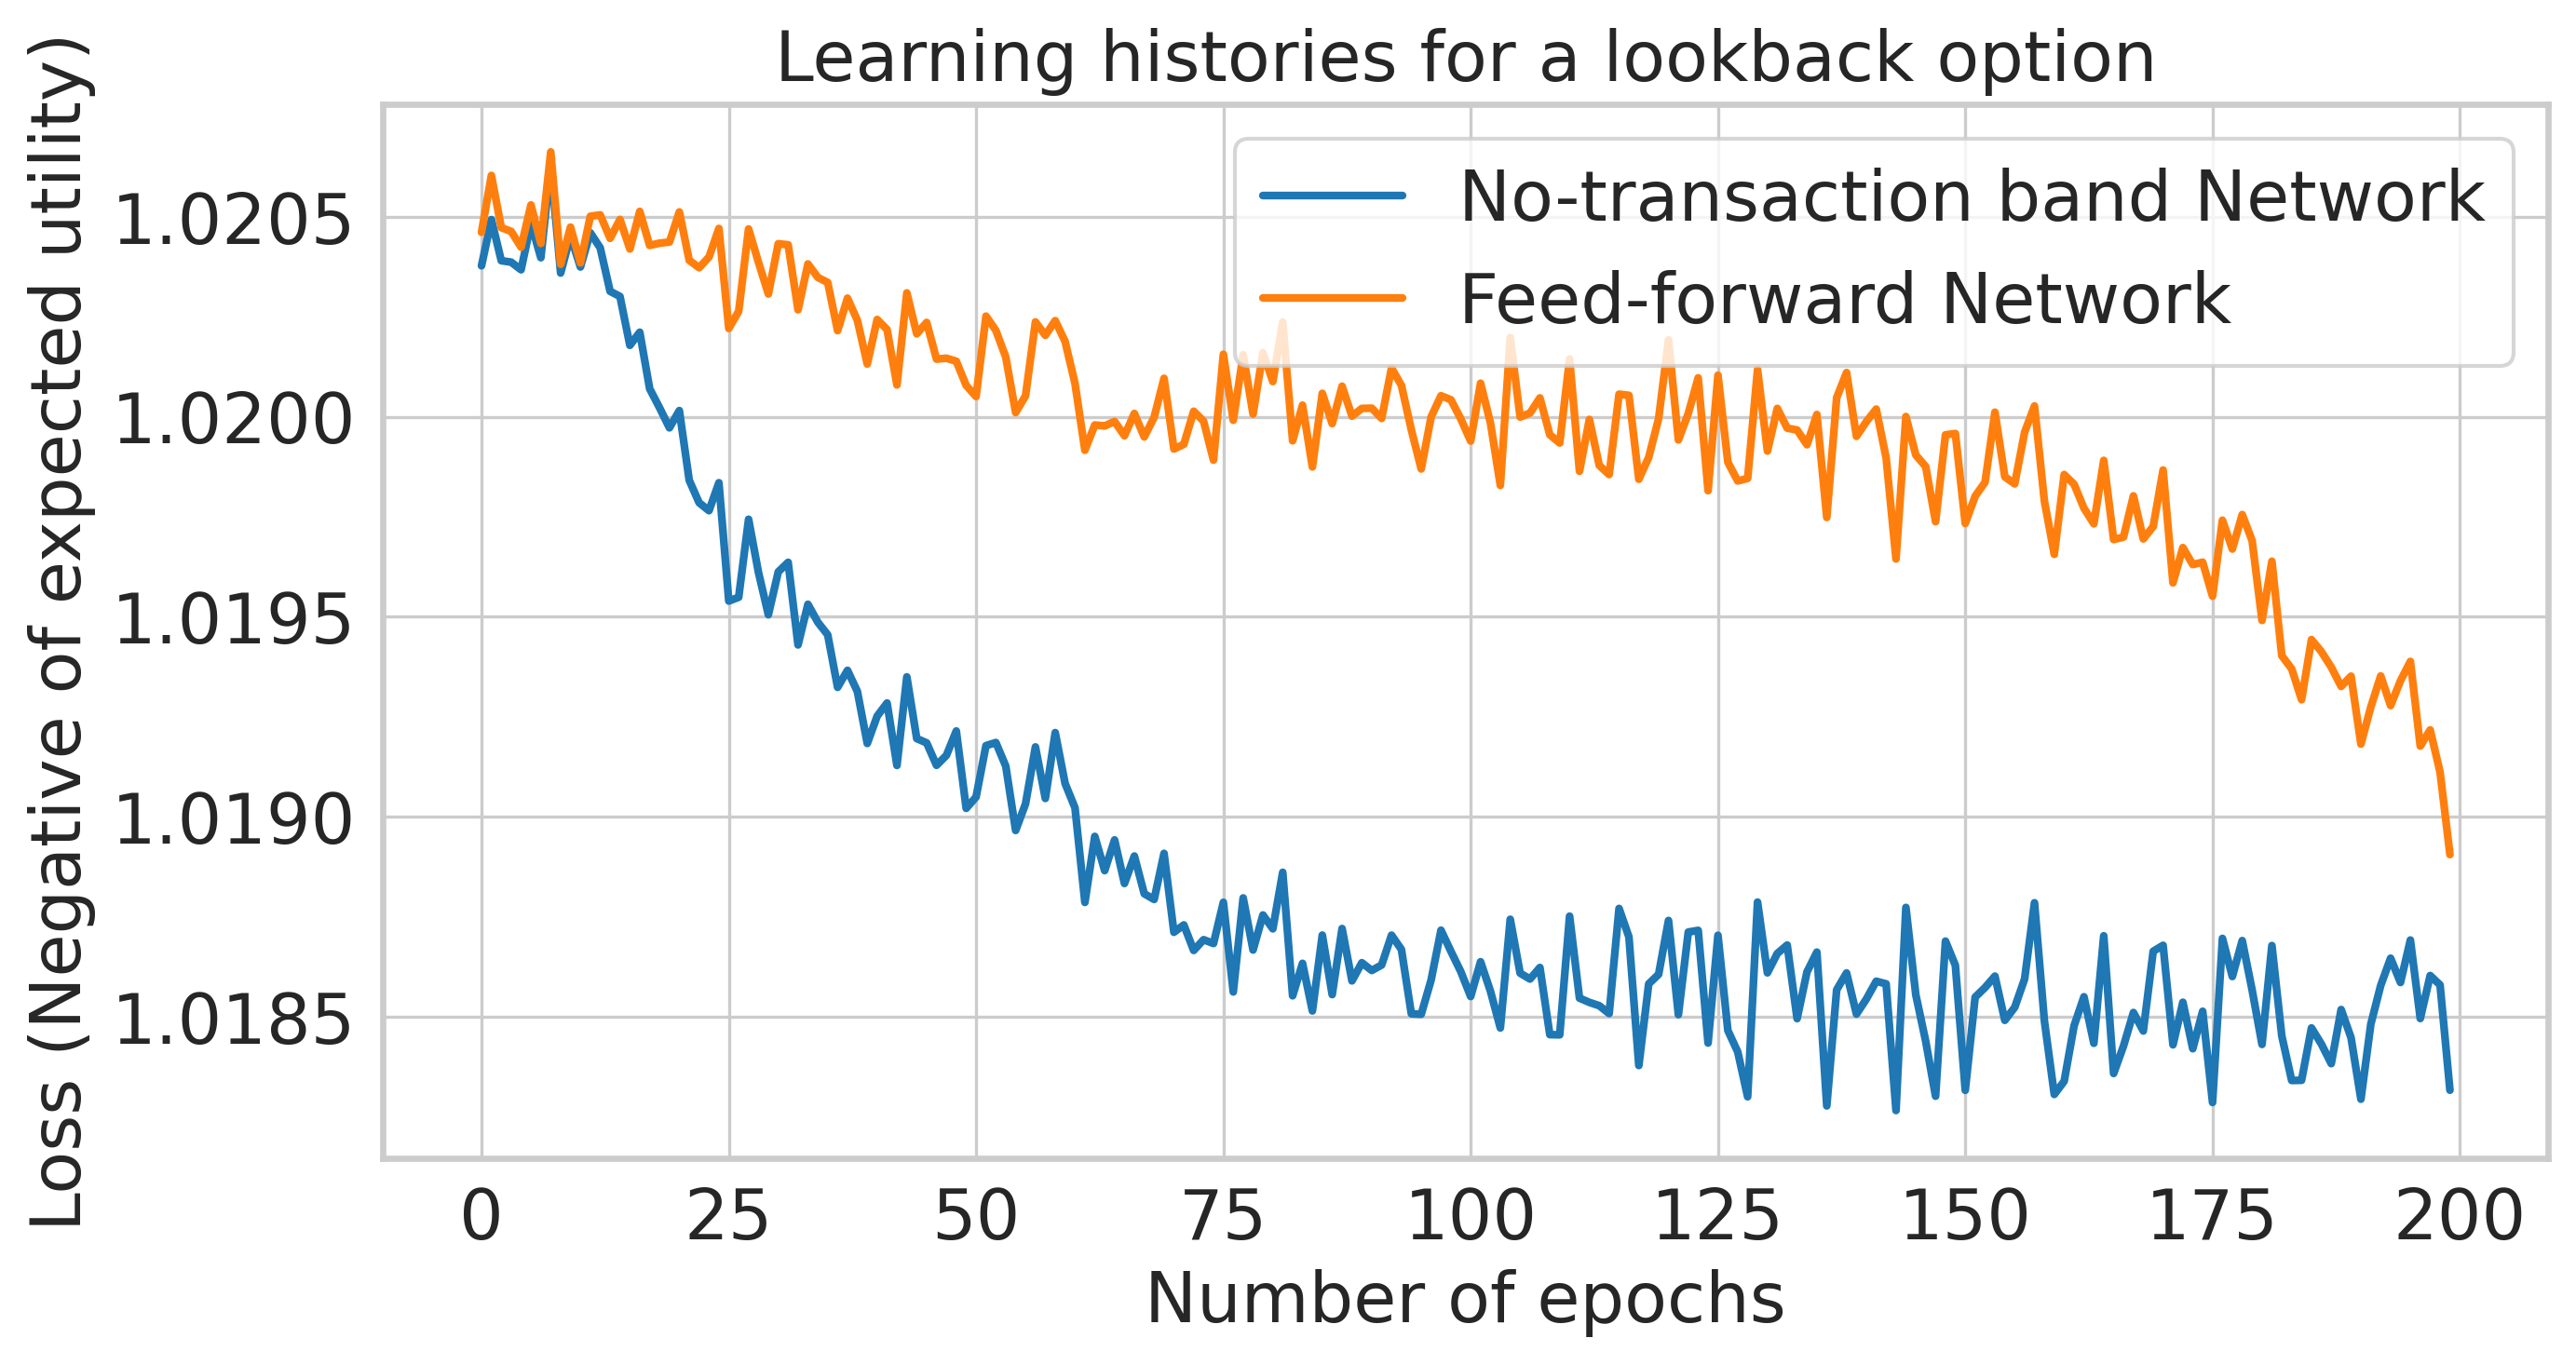

In [25]:
plt.figure()
plt.plot(history_ntb, label="No-transaction band Network")
plt.plot(history_ffn, label="Feed-forward Network")
plt.xlabel("Number of epochs")
plt.ylabel("Loss (Negative of expected utility)")
plt.title("Learning histories for a lookback option")
plt.legend()
plt.show()

Again, the above training histories exhibits that the no-transaction band network can be trained much quicker than the ordinary feed-forward network.

Surprisingly, the no-transaction band network achieves its optima as fast as it learns to hedge a European option, even though the lookback option bears further complication of path-dependence and needs more features.

### Evaluate the best premium of the derivative

In [26]:
th.manual_seed(42)
premium_ntb = evaluate_premium(model_ntb, lookback_option_payoff, cost=1e-3)
th.manual_seed(42)
premium_ffn = evaluate_premium(model_ffn, lookback_option_payoff, cost=1e-3)

The no-transaction band network again allows for a cheaper price.

In [27]:
print("Premium of a lookback option evaluated by the no-transaction band network :\t", premium_ntb)
print("Premium of a lookback option evaluated by the feed-forward band network   :\t", premium_ffn)

Premium of a lookback option evaluated by the no-transaction band network :	 0.018292717169970274
Premium of a lookback option evaluated by the feed-forward band network   :	 0.01881902841851115


In [28]:
premium_reduced = (premium_ffn - premium_ntb) / premium_ffn * 100
print("Reduced premium of a lookback option :\t", f"{premium_reduced:.4f} %")

Reduced premium of a lookback option :	 2.7967 %
